# Pneumonia_Training

Versions

* v001_Initial commit

Imports

In [22]:
# general
import numpy as np
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt
import datetime
import itertools
from scipy import misc

# keras
# from keras.applications.inception_v3 import InceptionV3
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.externals import joblib

Constants

In [127]:
# DATA_DIR = os.path.join(os.path.expandvars('%HOMEPATH%'), 'Downloads/Data')
DATA_DIR = os.path.join('C:/dev/datascienceworkshop-pneumonia/data')

TRAIN_DCM = os.path.join(DATA_DIR, "stage_1_train_images")
TEST_DCM = os.path.join(DATA_DIR, "stage_1_test_images")
TRAIN_IMAGES = os.path.join(DATA_DIR, "train_images")
TEST_IMAGES = os.path.join(DATA_DIR, "test_images")
TRAIN_IMAGES_POSITIVE = os.path.join(TRAIN_IMAGES, 'positive')
TRAIN_IMAGES_NEGATIVE = os.path.join(TRAIN_IMAGES, 'negative')

TRAIN_FEATURES_DIR = 'D:/Google Drive/Colab Notebooks/features'# os.path.join(TRAIN_IMAGES, 'features')
CLF_DIR = 'D:/Google Drive/Colab Notebooks/features/clf'

os.listdir(TRAIN_FEATURES_DIR)[:10]

['clf', 'negative', 'positive']

## Extract features using NN

In [14]:
from keras.applications.vgg16 import                VGG16
from keras.applications.vgg19 import                VGG19
from keras.applications.resnet50 import             ResNet50
from keras.applications.xception import             Xception
from keras.applications.inception_resnet_v2 import  InceptionResNetV2
from keras.applications.inception_v3 import         InceptionV3
from keras.applications.mobilenet import            MobileNet
from keras.applications.mobilenetv2 import          MobileNetV2
from keras.applications.densenet import             DenseNet121
from keras.applications.densenet import             DenseNet169
from keras.applications.densenet import             DenseNet201
from keras.applications.nasnet import               NASNetLarge
from keras.applications.nasnet import               NASNetMobile

class Model(object):

    def __init__(self, name, architecture, input_size, include_top, pooling):
        self.Name = name
        self.Architecture = architecture
        self.Input_size = input_size
        self.Include_top = include_top
        self.Pooling = pooling
        self.Model = None

    def CreateModel(self):
        self.Model = self.Architecture(weights='imagenet', include_top=self.Include_top, pooling=self.Pooling)


architectures = {
    "VGG16":VGG16,
    "VGG19":VGG19,
    "ResNet50":ResNet50,
    "Xception":Xception,
    "InceptionResNetV2":InceptionResNetV2,
    "InceptionV3":InceptionV3,
    # "MobileNet":MobileNet,
    "MobileNetV2":MobileNetV2,
    "DenseNet121":DenseNet121,
    # "DenseNet169":DenseNet169,
    "DenseNet201":DenseNet201,
    "NASNetLarge":NASNetLarge,
    # "NASNetMobile":NASNetMobile
}

input_size = {
    "VGG16":(224,224),
    "VGG19":(224,224),
    "ResNet50":(224,224),
    "Xception":(299,299),
    "InceptionResNetV2":(299,299),
    "InceptionV3":(299,299),
    # "MobileNet":(224,224),
    "MobileNetV2":(224,224),
    "DenseNet121":(224,224),
    # "DenseNet169":(224,224),
    "DenseNet201":(224,224),
    "NASNetLarge":(331,331),
    # "NASNetMobile":(224,224)
}


In [17]:
def dcm2np(dcm_path, target_size=(224, 224)):
    """ Transforms a dcm into a np.array
    """
    # --- Open DICOM file
    d = pydicom.read_file(dcm_path)
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)
    
    im = scipy.misc.imresize(im, target_size, interp='bilinear', mode=None)
    
    return im

def _collect_models():
    models = {}
    for key,value in architectures.items() :
        models[key] = Model(key, value, input_size[key], False, 'max')
    return models


def _generate_model(models):
    for key,value in models.items():
        #pos features
        pos_df = _create_pretrained_feature_df(os.path.join(TRAIN_IMAGES, "positive"), 
                                               value, 
                                               partition=1.0,
                                               target_size=input_size[key])

        #neg features
        neg_df = _create_pretrained_feature_df(os.path.join(TRAIN_IMAGES, "negative"), 
                                               value, 
                                               partition=0.25,
                                               target_size=input_size[key])
        
        del value.Model

def _get_feature_values(img_path, model, target_size):
    """ Get the feature values for a specific image out of pre-trained model 
    """
#     img = dcm2np(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x)[0].reshape(-1)

def _create_pretrained_feature_df(class_directory, model, partition=1.0, target_size=(224, 224)):
    """ Create features dataframe based on pretrained model 
    """

    features = []
    patientId = []
    
    #instantiate model
    model.CreateModel()
    m = model.Model
    
    print('')
    print('    ***')
    print('Inference for {0} {1}'.format(class_directory, model.Name))
    print('')
    
    path = os.path.normpath(class_directory)    
    csv_saveto = path.split(os.sep)[-1]


    def enumImgPath(class_directory,partition):
        max = len(os.listdir(class_directory))
        i=0
        for n, file in enumerate(os.listdir(class_directory)):
            if i > int(max*partition):
                break
            i+=1
            yield file
            
    divisor = 50
    n_max = len(os.listdir(class_directory))
   
    for n, file in enumerate(enumImgPath(class_directory,partition)):
        full_path = os.path.join(class_directory, file)
        features.append(_get_feature_values(full_path, m,target_size=target_size))
        patientId.append(file)
        
        csv_path = os.path.join(TRAIN_FEATURES_DIR,csv_saveto,'{0}_{1:05d}.csv'.format(model.Name,n))
        
        if( (n+1) % (n_max/divisor) ==0 ):
            print('Scoring image {0}'.format(n/n_max))
            df = pd.DataFrame(np.stack(features))
            df['patientID'] = patientId
            df.to_csv(path_or_buf=csv_path)
            print('Saved file {0}'.format(csv_path))
            features = []

    df = pd.DataFrame(np.stack(features))
    df['patientID'] = patientId
    df.to_csv(path_or_buf=csv_path)
    print('Saved file {0}'.format(csv_path))
            
    return pd.DataFrame(np.stack(features))

def _build_basic_rf(df):
    """ Build basic random forest based on extracted pre-trained model 
    """
    x_train, x_test, y_train, y_test = train_test_split(df[df.columns.difference(["Target"])], df["Target"])
    rf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=15, n_jobs=-1, class_weight="balanced")
    rf.fit(x_train, y_train)
    train_preds = rf.predict_proba(x_train)
    test_preds = rf.predict_proba(x_test)
    print('AUC for train set is {0}'.format(roc_auc_score(y_train, train_preds[:,1])))
    print('AUC for test set is {0}'.format(roc_auc_score(y_test, test_preds[:,1])))
    return rf

Extract features

In [ ]:
models = _collect_models()
_generate_model(models)

## Classifiers

In [31]:
classifiers = {
    "Nearest Neighbors":KNeighborsClassifier(3),
    "Linear SVM":SVC(kernel="linear", C=0.025, probability=True),
    "RBF SVM":SVC(gamma=2, C=1, probability=True),
    "Gaussian Process":GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    "Decision Tree":DecisionTreeClassifier(max_depth=5),
    "Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Neural Net":MLPClassifier(alpha=1),
    "AdaBoost":AdaBoostClassifier(),
    "Naive Bayes":GaussianNB(),
    "QDA":QuadraticDiscriminantAnalysis()
}

In [128]:
os.listdir(TRAIN_FEATURES_DIR)[:10]

['clf', 'negative', 'positive']

In [153]:
def ReadFeatureModel(name):

    subset = 2000
    
    # read negative/positive
    df_positive = pd.read_csv(os.path.join(TRAIN_FEATURES_DIR, 'positive', f'{name}_05658.csv'), index_col=0)
    df_negative = pd.read_csv(os.path.join(TRAIN_FEATURES_DIR, 'negative', f'{name}_05006.csv'), index_col=0)
    df_negative = df_negative.iloc[:len(df_positive)]

    df_positive = df_positive.iloc[:subset]
    df_negative = df_negative.iloc[:subset]

    df_positive['Target'] = 1
    df_negative['Target'] = 0

    df_positive['patientId'] = [os.path.splitext(f)[0] for f in os.listdir(TRAIN_IMAGES_POSITIVE)[:subset]]
    df_negative['patientId'] = [os.path.splitext(f)[0] for f in os.listdir(TRAIN_IMAGES_NEGATIVE)[:subset]]

    # append metadata to negative/positive
    if(False):
        metadata = pd.read_csv(os.path.join(TRAIN_IMAGES, 'metadata.csv'))
        metadata = metadata[['patient_id', 'patients_age']]
        df_neg = pd.DataFrame({'patientId': [os.path.splitext(f)[0] for f in os.listdir(TRAIN_IMAGES_NEGATIVE)[:subset]]})
        df_pos = pd.DataFrame({'patientId': [os.path.splitext(f)[0] for f in os.listdir(TRAIN_IMAGES_POSITIVE)[:subset]]})

        for _df in (df_neg, df_pos):
            ages = []
            for i, row in _df.iterrows():
                r = metadata.loc[metadata['patient_id'] == row['patientId']]
                ages.append(r['patients_age'].values[0])

            _df['age'] = ages

        df_positive['age'] = df_pos['age']
        df_negative['age'] = df_neg['age']
    else:
        for _df in (df_positive, df_negative):
            ages = []
            for i, row in _df.iterrows():
                # --- Open DICOM file
                dcm_path = os.path.join(TRAIN_DCM, row['patientId']) + '.dcm'
                d = pydicom.read_file(dcm_path)

                ages.append(d.PatientAge)

            _df['age'] = ages

    # concatenate the two datasets
    df = pd.concat([df_positive, df_negative])

    return df

#     df.head()

## Prepare feature dataset 

In [143]:
def PrepareDataSet(df):
    X = df.drop(['Target', 'patientId'], axis=1)
    Y = df['Target']
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4, random_state=42)
    return X_train, X_test, y_train, y_test

## Classification

In [112]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          index=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    rows=3
    ax = plt.subplot((len(classifiers) // rows) +1, rows, index+1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [151]:
def Classify(X_train, X_test, y_train, y_test):
    fig = plt.figure(figsize=(13, 13))

    #X_train, X_test, y_train, y_test
    for i, (name, clf) in enumerate(classifiers.items()):
        print('{0} - {1}'.format(datetime.datetime.now(), name))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        train_preds = clf.predict_proba(X_train)
        test_preds = clf.predict_proba(X_test)
        roc_train = roc_auc_score(y_train, train_preds[:,1])
        roc_test = roc_auc_score(y_test, test_preds[:,1])

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix

        plot_confusion_matrix(cnf_matrix, 
                              classes=['normal', 'recession'], 
                              normalize=True,
                              title='{0} - {1:.3f}\nROC train {2:.3f}, ROC test {3:.3f}'.format(name, score, roc_train, roc_test),
                              index=i)

    plt.tight_layout()
    plt.show()
    
    return fig

DenseNet121
2018-09-16 14:42:31.616730 - Nearest Neighbors
2018-09-16 14:42:31.716765 - Linear SVM
2018-09-16 14:42:31.865303 - RBF SVM
2018-09-16 14:42:32.026447 - Gaussian Process
2018-09-16 14:42:32.257113 - Decision Tree
2018-09-16 14:42:32.366480 - Random Forest
2018-09-16 14:42:32.444602 - Neural Net


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2018-09-16 14:42:33.028253 - AdaBoost
2018-09-16 14:42:33.679247 - Naive Bayes
2018-09-16 14:42:33.809956 - QDA


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


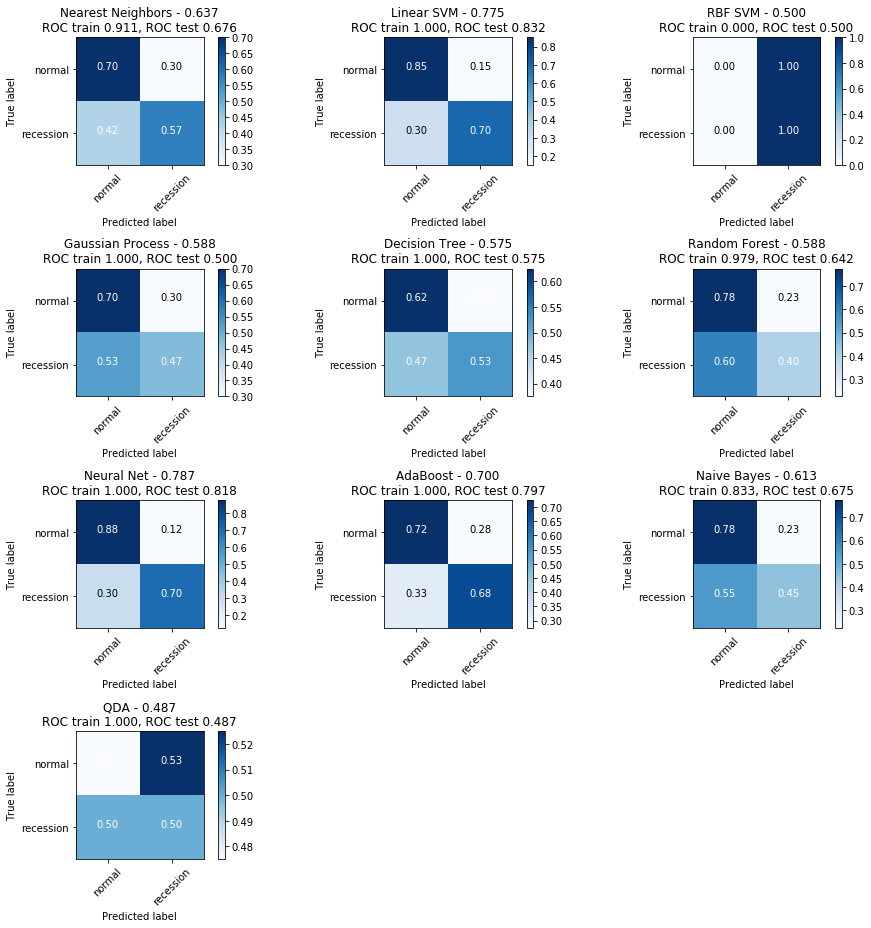

DenseNet169
2018-09-16 14:42:40.756073 - Nearest Neighbors
2018-09-16 14:42:40.881063 - Linear SVM
2018-09-16 14:42:41.096955 - RBF SVM
2018-09-16 14:42:41.331737 - Gaussian Process
2018-09-16 14:42:41.583112 - Decision Tree
2018-09-16 14:42:41.714181 - Random Forest
2018-09-16 14:42:41.802167 - Neural Net


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2018-09-16 14:42:43.782695 - AdaBoost
2018-09-16 14:42:44.730422 - Naive Bayes
2018-09-16 14:42:44.835464 - QDA


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


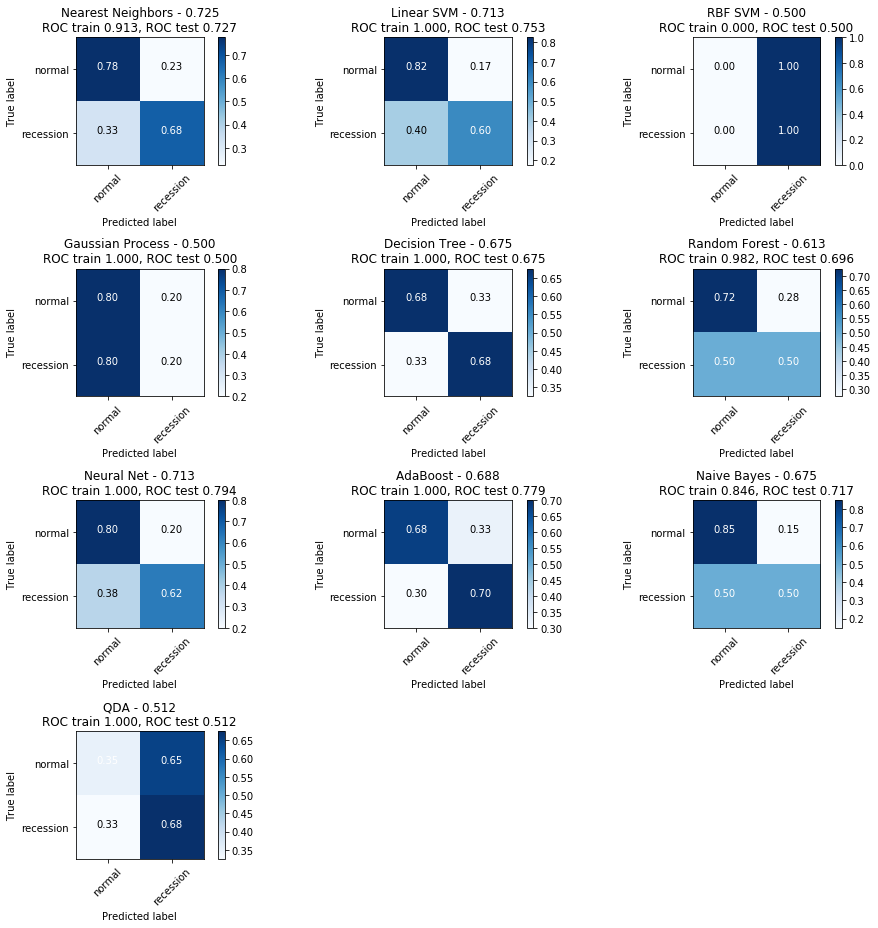

InceptionV3
2018-09-16 14:42:52.335776 - Nearest Neighbors
2018-09-16 14:42:52.476391 - Linear SVM
2018-09-16 14:42:52.733426 - RBF SVM
2018-09-16 14:42:53.046302 - Gaussian Process
2018-09-16 14:42:53.363133 - Decision Tree
2018-09-16 14:42:53.519371 - Random Forest
2018-09-16 14:42:53.614305 - Neural Net


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2018-09-16 14:42:55.959021 - AdaBoost
2018-09-16 14:42:57.045252 - Naive Bayes
2018-09-16 14:42:57.201462 - QDA


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


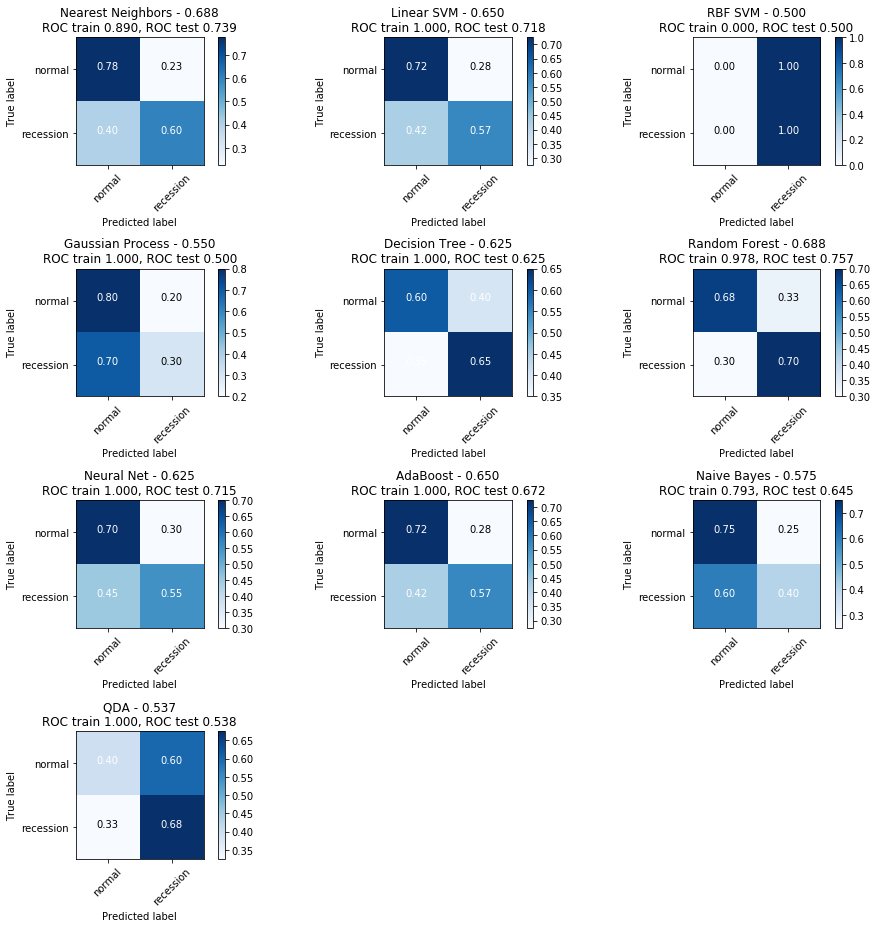

MobileNet
2018-09-16 14:43:01.453227 - Nearest Neighbors
2018-09-16 14:43:01.531344 - Linear SVM
2018-09-16 14:43:01.716937 - RBF SVM
2018-09-16 14:43:01.873204 - Gaussian Process
2018-09-16 14:43:02.092132 - Decision Tree
2018-09-16 14:43:02.170252 - Random Forest
2018-09-16 14:43:02.275057 - Neural Net


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2018-09-16 14:43:02.881753 - AdaBoost
2018-09-16 14:43:03.379247 - Naive Bayes
2018-09-16 14:43:03.504267 - QDA


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


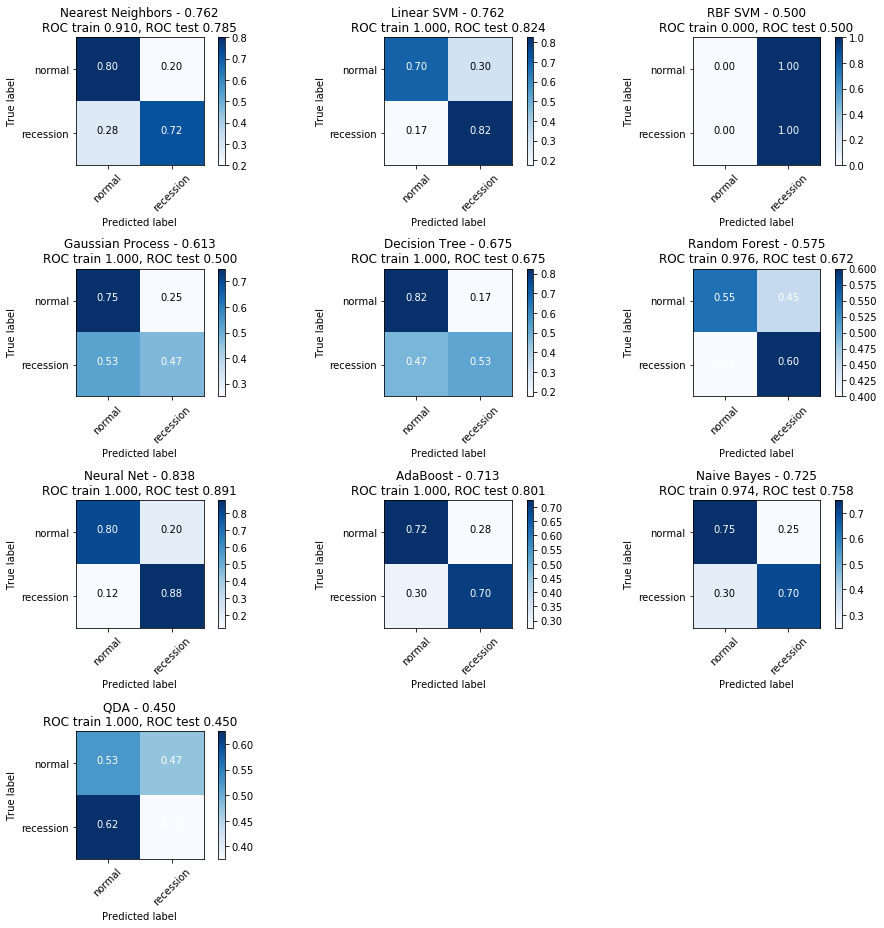

VGG16
2018-09-16 14:43:06.601821 - Nearest Neighbors
2018-09-16 14:43:06.668803 - Linear SVM
2018-09-16 14:43:06.758758 - RBF SVM
2018-09-16 14:43:06.897956 - Gaussian Process
2018-09-16 14:43:07.100481 - Decision Tree
2018-09-16 14:43:07.183499 - Random Forest
2018-09-16 14:43:07.261618 - Neural Net


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2018-09-16 14:43:07.745612 - AdaBoost
2018-09-16 14:43:08.122970 - Naive Bayes
2018-09-16 14:43:08.257916 - QDA


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


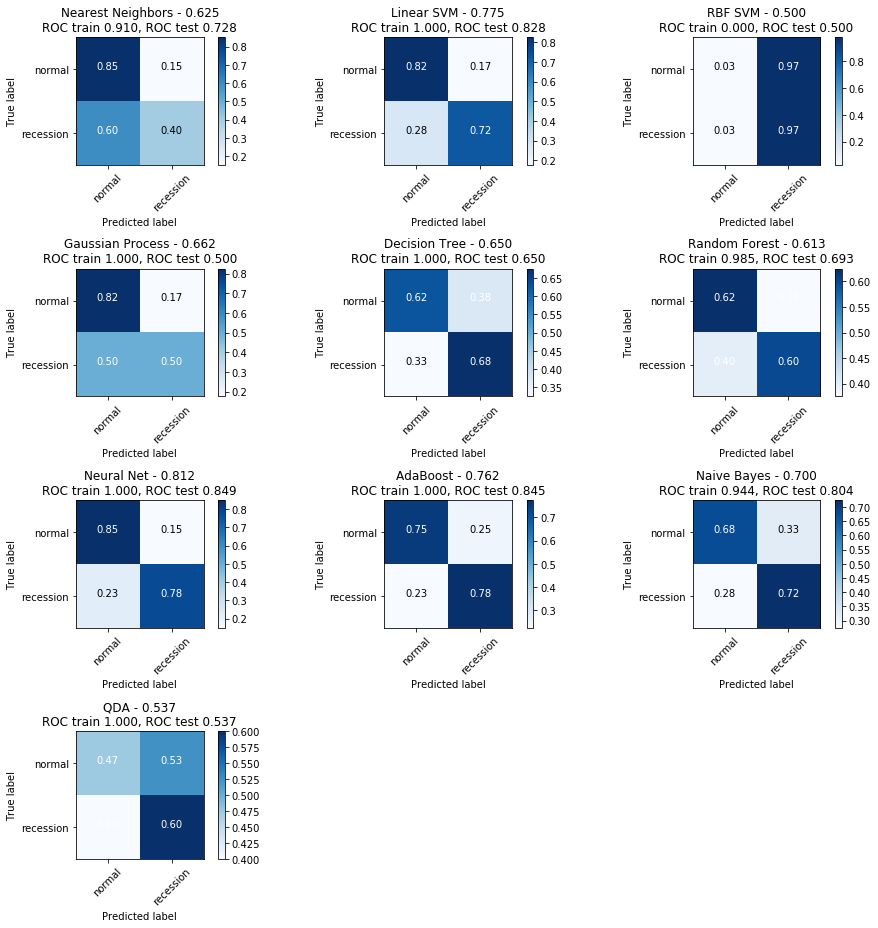

Xception
2018-09-16 14:43:15.972085 - Nearest Neighbors
2018-09-16 14:43:16.116003 - Linear SVM
2018-09-16 14:43:16.340801 - RBF SVM
2018-09-16 14:43:16.662861 - Gaussian Process
2018-09-16 14:43:17.011254 - Decision Tree
2018-09-16 14:43:17.143293 - Random Forest
2018-09-16 14:43:17.221412 - Neural Net


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2018-09-16 14:43:19.544503 - AdaBoost
2018-09-16 14:43:20.621620 - Naive Bayes
2018-09-16 14:43:20.740391 - QDA


C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


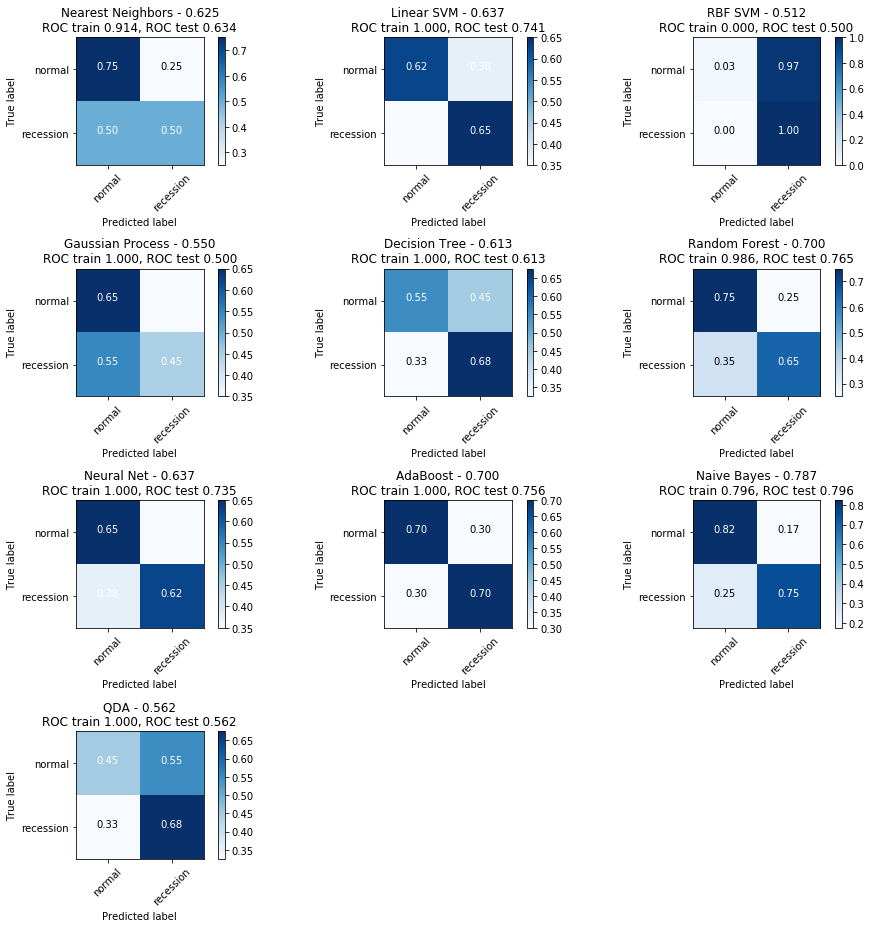

In [152]:
for name in os.listdir(os.path.join(TRAIN_FEATURES_DIR, 'positive')):
    name = os.path.splitext(name)[0]
    name = name.split(sep='_')[0]
    
    print(name)
    
    df = ReadFeatureModel(name)
    
    X_train, X_test, y_train, y_test = PrepareDataSet(df)
    
    fig = Classify(X_train, X_test, y_train, y_test)
        
    # save results
    clf_path = os.path.join(CLF_DIR, name)
    if not os.path.exists(clf_path):
        os.makedirs(clf_path)
    
    fig.savefig(os.path.join(clf_path, '{0}_benchmark.png'.format(name)))
    
    for clf_name, clf in classifiers.items():        
        joblib.dump(clf, '{0}/{1}.pkl'.format(clf_path, clf_name))
    

In [125]:
from sklearn.externals import joblib

for name, clf in classifiers.items():
    joblib.dump(clf, '{0}/{1}.pkl'.format(os.path.join(CLF_DIR, 'VGG16'), name))

In [ ]:
df_predictions = pd.DataFrame()

for i, (name, clf) in enumerate(classifiers.items()):
    print('{0} - {1}'.format(datetime.datetime.now(), name))
    
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    train_preds = clf.predict_proba(X_train)
    test_preds = clf.predict_proba(X_test)
    roc_train = roc_auc_score(y_train, train_preds[:,1])
    roc_test = roc_auc_score(y_test, test_preds[:,1])
             


## Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveRegressor, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20


    
class XgbWrapper(object):
    def __init__(self, seed=0):
        self.params = {"objective": "reg:linear", "booster":"gblinear"}
        self.nrounds = 250

    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.params, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

classifiers = {
    "PLSRegression": PLSRegression(n_components=2),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "MLPRegressor": MLPRegressor(max_iter=200,hidden_layer_sizes=(50)),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5 ),
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
}